In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd

In [2]:
from copy import deepcopy

import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [17]:
class MyTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, group_cols=None, transformer=None):
        self.transformer = transformer
        self.group_cols = group_cols

    def fit(self, X, y=None):
        x_in = X.drop([n for n in self.group_cols], axis=1)
        self.transformer = self.transformer.fit(X=x_in)
        return self

    def transform(self, X):
        x_in = X.drop([n for n in self.group_cols], axis=1)
        
        # transform the data
        transformed_x = self.transformer.transform(X=x_in)
        
        # convert data into initial format 
        transformed_x = pd.DataFrame(data=transformed_x, index=x_in.index, 
                                     columns=self.transformer.get_feature_names(x_in.columns))        
        transformed_x[list(self.group_cols)] = X[list(self.group_cols)]
        return transformed_x    

In [18]:
class FeatureSubsetModel(BaseEstimator, RegressorMixin):

    def __init__(self, group_cols=None, sub_models=None):
        """
        Build regression model for subsets of feature rows matching particular combination of feature columns.
        
        """

        self.group_cols = group_cols
        self.sub_models = sub_models

    def fit(self, X, y=None):
        """
        Partition the training data, X, into groups for each unique combination of values in 
        ``self.group_cols`` columns. For each group, train the appropriate model specified in 
        ``self.sub_models``.
        """
        groups = X.groupby(by=list(self.group_cols))

        for gp_key, x_group in groups:
            # Find the sub-model for this group key
            gp_model = self.sub_models[gp_key]
            
            # Drop the feature values for the group columns, since these are same for all rows
            # and so don't contribute anything into the prediction.
            x_in = x_group.drop([n for n in self.group_cols], axis=1)
            y_in = y.loc[x_in.index]

            # Fit the submodel with subset of rows
            gp_model = gp_model.fit(X=x_in.values, y=y_in.values)
            self.sub_models[gp_key] = gp_model
        return self

    def predict(self, X, y=None):
        """
        Same as ``self.fit()``, but call the ``predict()`` method for each submodel and return the results.
        """
        groups = X.groupby(by=list(self.group_cols))
        results = []

        for gp_key, x_group in groups:
            gp_model = self.sub_models[gp_key]
            x_in = x_group.drop([n for n in self.group_cols], axis=1)

            result = gp_model.predict(X=x_in.values)

            result = pd.Series(index=x_in.index, data=result)
            results.append(result)
        return pd.concat(results, axis=0)
    

In [19]:
def make_dataset(random_state, n_informative, **kwargs):
    x, y = make_regression(
        
        n_samples=1000, 
        n_features=5,
        noise=0 if random_state == 1 else 10,
        bias=10 if random_state == 1 else 1000,
        n_informative=min(n_informative, 5), 
        random_state=random_state
    )
    x = pd.DataFrame(x)
    x.columns = ['feature_{}'.format(n) for n in x.columns]
    x = x.assign(**kwargs)
    
    return x, pd.Series(y)

In [20]:
# Generate two sets of artificial regression data with different characteristics

x1, y1 = make_dataset(1, 5, account_banner='A', product_desc='X')
x2, y2 = make_dataset(2, 3, account_banner='B', product_desc='Y')

# combine into one dataset
total_x = pd.concat([x1, x2], axis=0, ignore_index=True).reset_index(drop=True)
total_y = pd.concat([y1, y2], axis=0, ignore_index=True).reset_index(drop=True)

# Split into train and test
train_index, test_index = train_test_split(total_x.index, random_state=5)
train_x, train_y = total_x.loc[train_index, :], total_y.loc[train_index]
test_x, test_y = total_x.loc[test_index, :], total_y.loc[test_index]

In [21]:
# Check Transformer method
from sklearn.preprocessing import PolynomialFeatures

subset_cols = ('account_banner', 'product_desc')
method =  PolynomialFeatures(2)

transformer = MyTransformer(group_cols=subset_cols, transformer=method)
transformer.fit(train_x)
transformed_test = transformer.transform(test_x)
transformed_test

,1,feature_0,feature_1,feature_2,feature_3,feature_4,feature_0^2,feature_0 feature_1,feature_0 feature_2,feature_0 feature_3,...,feature_1 feature_3,feature_1 feature_4,feature_2^2,feature_2 feature_3,feature_2 feature_4,feature_3^2,feature_3 feature_4,feature_4^2,account_banner,product_desc
51,1.0,0.540602,-1.318897,0.131092,0.845426,0.066393,0.292251,-0.712999,0.070869,0.457039,...,-1.115030,-0.087565,0.017185,0.110829,0.008704,0.714746,0.056130,0.004408,A,X
1327,1.0,-1.671151,1.284231,-0.117787,2.263467,0.890062,2.792746,-2.146144,0.196839,-3.782596,...,2.906815,1.143045,0.013874,-0.266606,-0.104837,5.123285,2.014626,0.792210,B,Y
1488,1.0,-0.986811,1.818890,-0.544084,0.277696,-1.135478,0.973795,-1.794900,0.536908,-0.274033,...,0.505098,-2.065309,0.296027,-0.151090,0.617795,0.077115,-0.315317,1.289309,B,Y
1432,1.0,0.931887,1.468332,-1.173156,-0.221321,-0.057847,0.868414,1.368320,-1.093249,-0.206246,...,-0.324973,-0.084939,1.376294,0.259644,0.067864,0.048983,0.012803,0.003346,B,Y
417,1.0,-0.358967,0.234771,-0.716644,1.476814,-0.751031,0.128858,-0.084275,0.257252,-0.530128,...,0.346713,-0.176320,0.513579,-1.058350,0.538222,2.180978,-1.109133,0.564047,A,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,1.0,-1.410339,-0.517696,-0.846935,-0.787852,-0.035732,1.989056,0.730126,1.194466,1.111138,...,0.407867,0.018498,0.717300,0.667259,0.030263,0.620710,0.028152,0.001277,B,Y
886,1.0,-1.040540,-0.157830,0.732108,1.438281,1.448543,1.082724,0.164229,-0.761788,-1.496590,...,-0.227004,-0.228624,0.535982,1.052977,1.060490,2.068654,2.083413,2.098278,A,X
1306,1.0,1.103019,-0.411301,0.249928,-0.182388,-0.073683,1.216651,-0.453673,0.275676,-0.201177,...,0.075016,0.030306,0.062464,-0.045584,-0.018415,0.033265,0.013439,0.005429,B,Y
279,1.0,1.562432,2.088828,-0.630349,0.330396,0.561341,2.441193,3.263652,-0.984877,0.516221,...,0.690140,1.172546,0.397340,-0.208265,-0.353841,0.109161,0.185465,0.315104,A,X


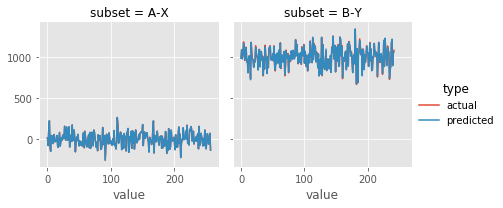

In [22]:
# Check Regressor method
sub_models = {
    ('A', 'X'): LinearRegression(),
    ('B', 'Y'): SGDRegressor(),
}
model = FeatureSubsetModel(group_cols=subset_cols, sub_models=sub_models)

model = model.fit(train_x, train_y)
results = model.predict(test_x)

comp = pd.concat({'actual':test_y, 'predicted': results}, axis=1)
cat_features = test_x.loc[:, ['account_banner', 'product_desc']].apply(lambda x: '-'.join(x.values), axis=1)
comp = pd.concat([comp, cat_features], axis=1)
comp.columns = ['actual', 'predicted', 'subset']

comp = comp.melt(id_vars=['subset',], var_name='type')
comp.head()
import seaborn as sns

# plot the predicted values of the target and the ground truth values for each subset.

fg = sns.FacetGrid(data=comp, col='subset', hue='type')
fg = fg.map(plt.plot, 'value')
fg = fg.add_legend()

In [23]:
# Create a pipeline and perform cross validation using both meth
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

subset_cols = ('account_banner', 'product_desc')
sub_models = {
    ('A', 'X'): LinearRegression(),
    ('B', 'Y'): SGDRegressor(),
}
method =  PolynomialFeatures(2)


pipe = Pipeline([  
  ('transform', MyTransformer(group_cols=subset_cols, transformer=method)),
  ('estimate', FeatureSubsetModel(group_cols=subset_cols, sub_models=sub_models))
])

scores = cross_val_score(pipe, train_x, train_y, cv=10, scoring='r2')
print('10-fold Cross-Validation scores:\n{}'.format(scores))

10-fold Cross-Validation scores:
[-0.96009873 -1.02967654 -1.42444745 -1.10120506 -1.13963654 -1.17274441
 -1.10714481 -0.89412126 -0.99270212 -0.70224627]
